In [1]:
# Preamble

from astropy.table import Table, column
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

In [38]:
import sys
sys.path.append('../astro_codes/')

### Here, we want to find (once and for all) a method for measuring pitch angles reliably from SpArcFiRe. If we wish, we can call upon three datasets:

1. SpArcFiRe itself: automated detection of spiral arms.
2. GZ2: spiral arm _numbers_
3. GZ1: should have the most reliable chirality measure here.

#### Perhaps the method could look something like this:

1. Pick/check the chirality. Clip away any arms that don't agree with the dominant chirality.
2. Seigar+, Block+99: 10 < P < 45: perhaps clip away these arms too (have an issue with tightly wound arcs towards the centre of galaxies showing up)

In [2]:
# Load the data:
gz_data = Table.read('../fits/full_sample_debiased_w_low_z.fits')

In [3]:
sparcfire_g = Table.read('../sparcfire_directories/main/sparcfire_g_matched.fits')

In [4]:
sparcfire_r = Table.read('../sparcfire_directories/main/sparcfire_r_matched.fits')

In [5]:
sparcfire_i = Table.read('../sparcfire_directories/main/sparcfire_i_matched.fits')

In [6]:
samples = Table.read('../fits/SF_fits/samples.fits')

In [7]:
# First, create the masks:

def spiral_selection(table,p_min=0.5,N_min=5,pbar_max=None):
    p_spiral = (table['t01_smooth_or_features_a02_features_or_disk_debiased_rh']*
                table['t02_edgeon_a05_no_debiased_rh']*
                table['t04_spiral_a08_spiral_debiased_rh'])
    N_spiral = (table['t04_spiral_a08_spiral_count'] - 
                table['t11_arms_number_a37_cant_tell_debiased_rh'])
    
    if pbar_max is not None:
        p_bar = table['t03_bar_a06_bar_debiased_rh']
        mask = (N_spiral >= N_min) & (p_spiral > p_min) & (p_bar < pbar_max)
    else:
        mask = (N_spiral >= N_min) & (p_spiral > p_min)
    return mask

in_g = sparcfire_g['fit_state'] == 'OK'
print('{} in SpArcFiRe g-sample'.format(in_g.sum()))
in_r = sparcfire_r['fit_state'] == 'OK'
print('{} in SpArcFiRe r-sample'.format(in_r.sum()))
in_i = sparcfire_i['fit_state'] == 'OK'
print('{} in SpArcFiRe i-sample'.format(in_i.sum()))
in_all = (in_g) & (in_r) & (in_i)

158448 in SpArcFiRe g-sample
148025 in SpArcFiRe r-sample
149298 in SpArcFiRe i-sample


### First, we will work on this 'secure' sample of spirals
*we will, however, have to extend this out to the full sample in order to show it works properly. This is merely a 'proof of concept'

Here, we will directly compare the g,r and i SpArcFiRe efforts.

In [8]:
### Now, need to relax this for a less 'secure' sample:
from tabulate import tabulate

in_redshift = (gz_data['REDSHIFT_1'] > 0.02) & (gz_data['REDSHIFT_1'] <= 0.055)

def calculate_arc_statistic(data,m_values):
    
    length_strings = ['000','010','020','040','050',
                      '055','060','065','070','075',
                      '080','085','090','095','100',
                      '120','140','160','180','200',
                      '220','240','260','280','300',
                      '350','400','450','500','550',
                      '600']
    
    arc_columns = ['numDcoArcsGE{}'.format(l) for l in length_strings]
    chi2_statistic = []
    ratio_statistic = []
    for c in arc_columns:
        chi = data[c] - m_values
        chi2_statistic.append(np.mean(np.abs(chi)))
        ratio = data[c]/m_values
        ratio_statistic.append(np.mean(np.abs(ratio-1)))
        #ratio_statistic.append(np.mean(ratio))
    
    length_values = [0,10,20,40,50,
                     55,60,65,70,75,
                     80,85,90,95,100,
                     120,140,160,180,200,
                     220,240,260,280,300,
                     350,400,450,500,550,
                     600]

    stats_table = Table(np.array([length_values,chi2_statistic,ratio_statistic]).T,
                        names=('L_min','chi2','ratio'))

    return stats_table


def select_spiral_sample(data,p=0.5,N=5,p_m=0.5,p_bar=0.5,
                         printout=True):
    
    spiral_ok = (spiral_selection(data,p,N,p_bar)) & (in_redshift)
    
    mlabels = ('1','2','3','4','5+')
    
    m_columns = ['t11_arms_number_a31_1_debiased_rh',
                 't11_arms_number_a32_2_debiased_rh',
                 't11_arms_number_a33_3_debiased_rh',
                 't11_arms_number_a34_4_debiased_rh',
                 't11_arms_number_a36_more_than_4_debiased_rh']
    
    m_table = np.array([data[c] for c in m_columns]).T
    mode_m = np.argmax(m_table,axis=1)
    max_m = np.max(m_table,axis=1)
    m_ok = max_m >= p_m
    m_table = Table(np.array([mode_m,spiral_ok,m_ok]).T,
                    names=('m','spiral_ok','m_ok'))
    if printout is True:
        print('{} spirals selected'.format(spiral_ok.sum()))
        print('--> {} have p_m > 0.5'.format((spiral_ok*m_ok).sum()))
        table_array = np.empty((5,2),dtype='U10')
        table_array[:,0] = mlabels
        for m in range(5):
            in_m = m_ok*spiral_ok*(mode_m == m)
            table_array[m,1] = in_m.sum().astype(str)
        print(tabulate(table_array,headers=('m','N'),
                       tablefmt="fancy_grid"))
    return m_table


def plot_paramaters(m_table,in_filters):

    fig, axarr = plt.subplots(5,1,figsize=(10,15),
                              sharex=True)

    fig.subplots_adjust(hspace=0,wspace=0)

    colors = ['orange','r','m','g','b']
    mlabels = ['1','2','3','4','5+']
    styles = ['dotted','solid','dashed']
    linewidths = [3,1,2]

    for m in range(5):
        in_m = ((m_table['spiral_ok']) & (in_filters) & 
                (m_table['m_ok']) & (m_table['m'] == m)).astype(bool)
        plt.sca(axarr[m])
        
        best_L = []
        for f, filt in enumerate([sparcfire_g,sparcfire_r,sparcfire_i]):   
            arc_stats = calculate_arc_statistic(filt[in_m],m+1)
            _ = plt.plot(arc_stats['L_min'],arc_stats['chi2'],
                         color=colors[m],linewidth=linewidths[f],
                         linestyle=styles[f])
            best_L.append(np.min(arc_stats['L_min'][np.argmin(arc_stats['chi2'])]))
        ranges = plt.ylim()
        for f in range(3):
            _ = plt.vlines(best_L[f],*ranges,color='k',
                           linewidth=linewidths[f],linestyle=styles[f])
        plt.ylim(ranges)
        #plt.ylabel('$(N_\mathrm{arcs}/N_\mathrm{arms})$')
        plt.text(0.975,0.05,
                 '$m={} \, \, (N_\mathrm{{gal}}={})$'.format(mlabels[m],in_m.sum()),
                 transform=axarr[m].transAxes,ha='right',va='bottom')
        #plt.ylabel('$|N_\mathrm{arcs}/N_\mathrm{arms}-1|$')
        plt.ylabel('$|\chi|$')

    axarr[-1].set_xlabel('$L_\mathrm{min}$')
    axarr[-1].plot([],[],'k:',linewidth=3,label='g')
    axarr[-1].plot([],[],'k-',linewidth=1,label='r')
    axarr[-1].plot([],[],'k--',linewidth=2,label='i')
    axarr[-1].legend(fontsize=15)
    axarr[-1].set_xlim(0,200)
    
    return None

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in greater_equal
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


6641 spirals selected
--> 2877 have p_m > 0.5
╒═════╤══════╕
│ m   │    N │
╞═════╪══════╡
│ 1   │   75 │
├─────┼──────┤
│ 2   │ 2009 │
├─────┼──────┤
│ 3   │  465 │
├─────┼──────┤
│ 4   │  126 │
├─────┼──────┤
│ 5+  │  202 │
╘═════╧══════╛


/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


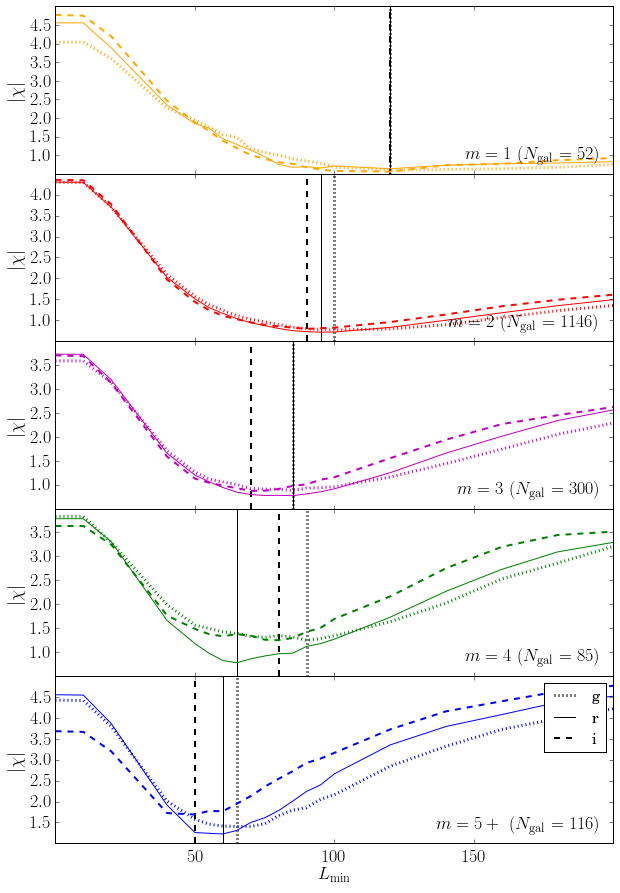

In [9]:
m_table = select_spiral_sample(gz_data,p=0.8,p_m=0.5)
_ = plot_paramaters(m_table,in_all)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in greater_equal
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


11131 spirals selected
--> 3996 have p_m > 0.5
╒═════╤══════╕
│ m   │    N │
╞═════╪══════╡
│ 1   │  195 │
├─────┼──────┤
│ 2   │ 2947 │
├─────┼──────┤
│ 3   │  502 │
├─────┼──────┤
│ 4   │  138 │
├─────┼──────┤
│ 5+  │  214 │
╘═════╧══════╛


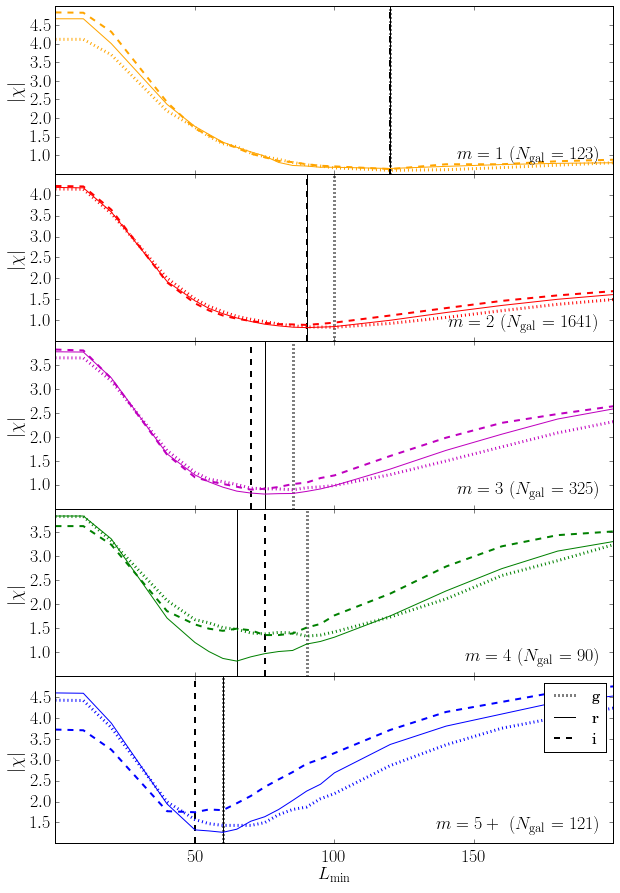

In [10]:
m_table = select_spiral_sample(gz_data,p_m=0.5)
_ = plot_paramaters(m_table,in_all)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in greater_equal
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


11131 spirals selected
--> 11131 have p_m > 0.5
╒═════╤══════╕
│ m   │    N │
╞═════╪══════╡
│ 1   │  983 │
├─────┼──────┤
│ 2   │ 5981 │
├─────┼──────┤
│ 3   │ 2073 │
├─────┼──────┤
│ 4   │  861 │
├─────┼──────┤
│ 5+  │ 1233 │
╘═════╧══════╛


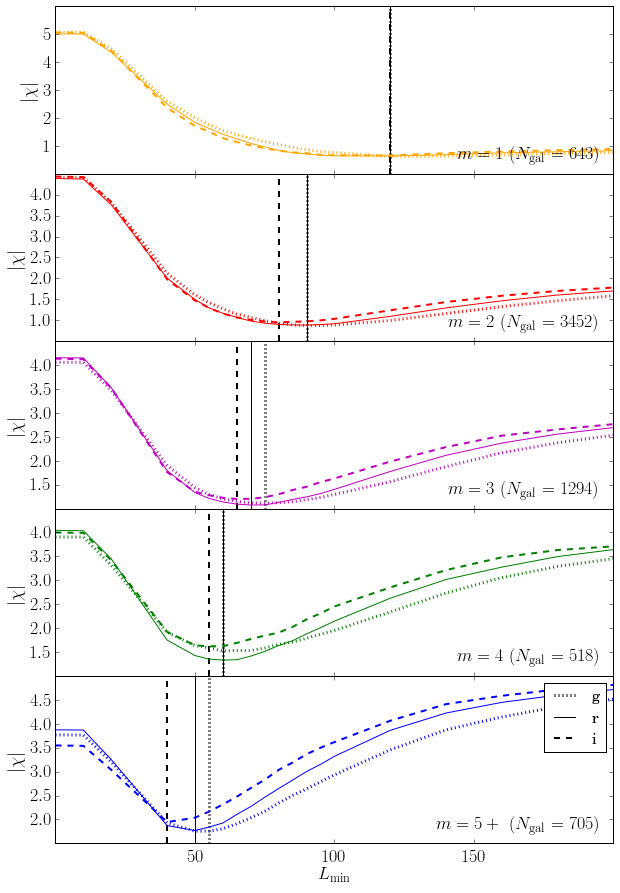

In [11]:
m_table = select_spiral_sample(gz_data,p_m=0)
_ = plot_paramaters(m_table,in_all)

### Notes on this section:

1. When making a 'cleaner' selection, the performance of SpArcFiRe is improved.
2. More arms = need a shorter min. arc length to get the best performance.
3. Generally, the g and i band are comparable. However, the g-band may actually be preferable here: we retain longer arcs in the g-band than in the r-band. The i-band is usually the worst on both counts.

### Now, I'll create a 100 galaxy subset to test on.

In [14]:
## Now, get the equivalent images from SpArcFiRe:
import paramiko
from scp import SCPClient
import os
import shutil

def open_client():

    ssh_client = paramiko.SSHClient()
    ssh_client.load_system_host_keys()
    ssh_client.connect('bayonet-08.ics.uci.edu',username='zoo',password='GalaxyZoo2')
    scp_client = SCPClient(ssh_client.get_transport())
    sftp = ssh_client.open_sftp()
    return ssh_client, scp_client, sftp


def close_client(ssh_client,scp_client,sftp_client):
    ssh_client.close()
    scp_client.close()
    sftp.close()
    return None


def download_galaxy_directory(dr8id,reload=False,filt='r'):
    
    id_string = str(dr8id)
    id_suffix = id_string[-3:]
    filter_directory =  '/home/ppxrh/Github_repos/sparcfire_directories/{}'.format(filt)
    if os.path.isdir(filter_directory) is False:
        os.mkdir(filter_directory)
    # does the required directory already exist?
    local_directory = filter_directory + '/{}'.format(id_string)
    directory_exists = os.path.isdir(local_directory)
    
    if (reload is True) & (directory_exists is True):
        shutil.rmtree(local_directory)
        directory_exists = False
    
    if directory_exists is False:
        os.mkdir(local_directory)
        remote_directory = ('/home/zoo/SpArcFiRe/SpArcFiRe/'
                            '{}/{}/{}'.format(filt,id_suffix,id_string))
        scp_client.get(remote_directory,filter_directory,recursive=True)
    
    return local_directory

In [15]:
#ssh_client, scp_client, sftp = open_client()

local_directories = []
for id_ in subset_ids:
    local_dir = download_galaxy_directory(id_,filt='g')
    local_directories.append(local_dir)
#close_client(ssh_client,scp_client,sftp)

### Now, inspect a subset of galaxies in more detail:

Here, we aim to get ~1000 galaxies which have spiral arms measured by SpArcFiRe. This sample will be representative of the total sample (ie. ~50% m=2).

In [61]:
# create a subset of N_gal galaxies to test on
N_subset = 1000

np.random.seed(0)

in_both = (m_table['spiral_ok']) & (in_all)
random_subset = np.zeros(len(gz_data))
indices = np.arange(len(gz_data))
subset_indices = []
subset_ids = []
subset_m_values = []

for m in range(5):
    in_m = (m_table['m_ok'] == 1) & (m_table['m'] == m)
    N_m = int(np.round((in_m*in_both).sum()/in_both.sum()*N_subset))
    subset_m = np.random.choice(indices[(in_m*in_both).astype(bool)],N_m)
    for s in subset_m:
        subset_m_values.append(m)
        subset_indices.append(s)
        subset_ids.append(gz_data['dr8objid'][s])
        
subset_array = np.array([subset_ids,subset_indices,subset_m_values]).T
subset_table = Table(subset_array,names=('id','row_index','m'))

In [64]:
import pandas as pd

# A clean, efficient method for reading in the SpArcFiRe 'arcs' csvs is to use pandas:
#arc_data = pd.read_csv('../sparcfire_directories/g/g.galaxy_arcs.csv')

### PAs for NGC objects: ithis sample has been selected as a grand design set of spirals, so is unlikely to be fully 
# representatative.'.', it _does_ give us a chance to check whether the range of measured P values is 'reasonable'. 

osubgs_angles = [8.4,25.2,25.7,18,26.4,46.4,17.6,31.1,15.7,50.3,31.7,48.8,42.1,
                 20.3,26.4,46.9,10.7,21.2,13.6,24,28.1,32.5,21.7,15.3,32,31,
                 24.9,18.2,35.7,19.8,18.3,43.3,13.2,24.8,22.1,32.1,40.4,22.4,
                 17.8,49.3,16.3,49.5,38.7,29.6,25.1,36.7,40.4,26.2,17.8,20.3,
                 24.9,29.4,22.3,17.8,19.3,16.1,28.5]

seigar_angles = [23.7,10.5,22.6,38.8,9.3,24.6,38.3,14.1,8.4,36.1,18,12.9,19.3,
                 29.8,31.7,36.6,35.4,20.4,36,13.8,24.2,24,19.5,14.1,19.8,42.9,
                 10.7,36.9,47.3,26.7,24.6]

all_angles = osubgs_angles + seigar_angles # All gals. from Seigar+06, measured in the B-band.

In [65]:
def get_arcs(arc_data,dr8id,return_mask=False):
    '''
    This function will return all of the arcs from a given SpArcFiRe catalogue
    which match the dr8id. 
    '''
    arc_mask = arc_data['gxyName'] == dr8id
    arcs = arc_data[arc_mask]
    if return_mask is True:
        return arcs, arc_mask
    else:
        return arcs
    
    
def reduce_arcs(arcs,m=None,min_length=50,
                P_range=None,chirality='S-wise'):
    '''
    This reduces the number of arcs in the table: we can cut out arcs which don't match
    the chirality, only keep arcs above a given length, and possibly only keep arcs in a 
    "reasonable" pitch angle range. 
    '''
    arcs = arcs.sort('arc_length',ascending=False)
    
    if P_range is not None:
        ok_P = (((arcs['pitch_angle'] >= P_range[0]) & 
                 (arcs['pitch_angle'] <= P_range[1])) | 
                ((arcs['pitch_angle'] >= -P_range[1]) & 
                 (arcs['pitch_angle'] <= -P_range[0])))
        ok_P = np.array(ok_P.values)
    else:
        ok_P = np.ones(len(arcs)).astype(bool)

    ok_L = arcs['arc_length'] > min_length
    ok_L = np.array(ok_L.values).astype(bool)
    if chirality == 'S-wise':
        ok_chirality = arcs['pitch_angle'] > 0
    else:
        ok_chirality = arcs['pitch_angle'] < 0
    ok_chirality = np.array(ok_chirality.values).astype(bool)
    ok_all = ok_L*ok_P*ok_chirality
    arcs_less = arcs[ok_all]
    if m is not None:
        if len(arcs_less) > m:
            arcs_less = arcs_less[:m]
    
    return arcs_less


def get_P(ids,sparcfire,arc_data,
          min_length=50,P_range=None):
    '''
    Measure the pitch angle using the length weighted average method. This function
    calls the reduce arcs method above, with adjustable P and L paramaters.
    '''
    N_arcs = []
    P_mean = []
    
    for id_ in ids:
        arcs = get_arcs(arc_data,id_)
        sparcfire_row = sparcfire[sparcfire['dr8objid'] == id_]
        chirality = sparcfire_row['chirality_alenWtd']
        arcs = get_arcs(arc_data,id_)
        arcs_reduced = reduce_arcs(arcs,chirality=chirality,
                                   P_range=P_range,min_length=min_length)
        if len(arcs_reduced) > 0:
            P_mean.append(np.average(arcs_reduced['pitch_angle'],
                           weights=arcs_reduced['arc_length']))
            N_arcs.append(len(arcs_reduced))
        else:
            P_mean.append(-999)
            N_arcs.append(0)
    P_array = np.array([N_arcs,P_mean]).T
    P_table = Table(P_array,names='NP')
    return P_table

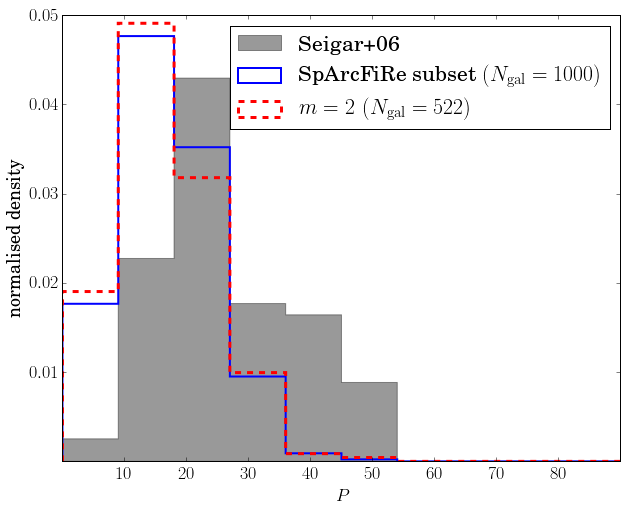

In [81]:
bins = np.linspace(0,90,11)

#P_mean = get_P(subset_table['id'],sparcfire_g,arc_data)

_ = plt.hist(all_angles,normed=True,bins=bins,
             histtype='stepfilled',alpha=0.4,color='k',
             label='Seigar+06')

x = np.abs(P_mean['P'])
_ = plt.hist(x,normed=True,bins=bins,
             histtype='step',linewidth=2,
             label='SpArcFiRe subset $(N_\mathrm{{gal}} = {})$'.format(len(x)))

m_2 = subset_table['m'] == 1
x = np.abs(P_mean['P'][m_2])
_ = plt.hist(x,normed=True,bins=bins,
             linewidth=3,color='r',linestyle='dashed',histtype='step',
             label='$m=2 \,\,(N_\mathrm{{gal}} = {})$'.format(len(x)))

_ = plt.legend()
_ = plt.xlabel('$P$')
_ = plt.ylabel('normalised density')

### Now we will consider whether there is a 'paramater range' to zone in on that will give the most 'desirable' characteristics.

We will consider _two_ variables:
1) P<sub>min</sub> : Impose a limit on the lower bound for a possible arc. We know from the literature (Seigar+06) that in grand design spirals at least, the range of pitch angles measured is 10 $\lesssim$ P $\lesssim$ 45. As seen in the figure above, we find very few P values $\gtrsim$45, but a lot of low-P arcs.

2) L<sub>min</sub>: we have also already seen that we need to remove the shortest arcs to get the most desirable behaviour. 

==========================================

Using our small (~1000 galaxy) subset, we shall see if there _is_ a desirable set of params that lead to the 'best' measure of P. We will use two statistics:

1) $\rho(P,P_\mathrm{GZ2})$ : where do we find the best correlation between the GZ2 wining scores measured by eye and the measured P values?

2) $N_\mathrm{arcs}$: as above, when does the number of arcs match the number of arms?

In [82]:
# Measure a 'winding score':

winding_columns = ['t10_arms_winding_a28_tight_debiased_rh',
                   't10_arms_winding_a29_medium_debiased_rh',
                   't10_arms_winding_a30_loose_debiased_rh']

p_total = np.zeros(len(gz_data))
winding_score = np.zeros(len(gz_data))
for w, column in enumerate(winding_columns):
    p_total += gz_data[column]
    winding_score += gz_data[column]*(w/2)
winding_score /= p_total
winding_score[np.isfinite(winding_score) == False] = -999

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


In [27]:
subset_2 = subset_table[subset_table['m'] == 1]
subset_2_winding_score = winding_score[subset_2['row_index']]

In [99]:
# now, run this on a grid of P and L, using the subset of ~522 m=2 galaxies.
P_mins = np.array(np.linspace(0,20,8))
L_mins = np.array(np.linspace(50,150,8))

P_grid, L_grid = np.meshgrid(P_mins,L_mins)
PL_grid = np.array([P_grid.ravel(),L_grid.ravel()]).T

P_tables = []

for i in range(len(PL_grid)):
    P_min, L_min = PL_grid[i,:]
    P_table = get_P(subset_2['id'],sparcfire_g,arc_data,
                    min_length=L_min,P_range=(P_min,90))
    P_tables.append(P_table)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:21: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [135]:
from scipy.stats import spearmanr

def calculate_statistic(table,m=2):
    
    arcs_ok = table['N'] > 0
    f_ok = arcs_ok.sum()/len(arcs_ok)
    table['N'][table['N'] < 0] = 0 #?
    table['P'][table['N'] < 0] = 0 #?
    chi = table['N'] - m 
    chi_mean = np.mean(np.abs(chi))
    rho, _ = spearmanr(table['P'][arcs_ok],subset_2_winding_score[arcs_ok]) #[arcs_ok]?
    return chi_mean, rho, f_ok

In [136]:
chis = []
rhos = []
fs = []

for P_table in P_tables:
    chi,rho,f_ok = calculate_statistic(P_table)
    chis.append(chi)
    rhos.append(rho)
    fs.append(f_ok)
arm_stats = Table(np.array([chis,rhos,fs]).T,
                  names=('chi','rho','f_ok'))

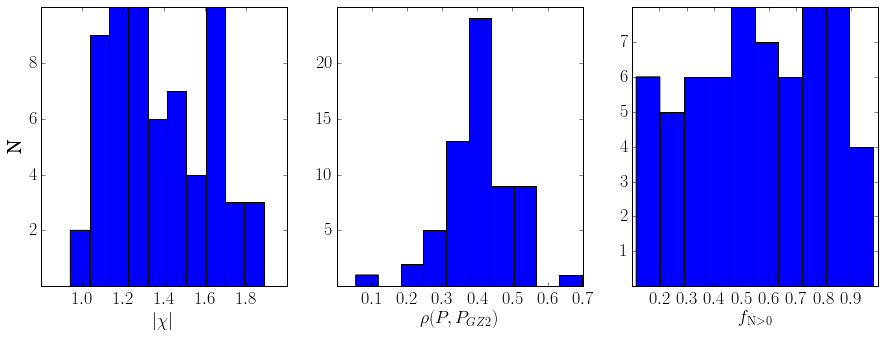

In [149]:
fig, axarr = plt.subplots(1,3,figsize=(15,5))
axarr[0].hist(arm_stats['chi'])
axarr[1].hist(arm_stats['rho'])
axarr[2].hist(arm_stats['f_ok'])
axarr[0].set_xlabel('$|\chi|$')
axarr[1].set_xlabel(r'$\rho(P,P_{GZ2})$')
axarr[2].set_xlabel(r'$f_\mathrm{N>0}$')
axarr[0].set_ylabel('N')

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


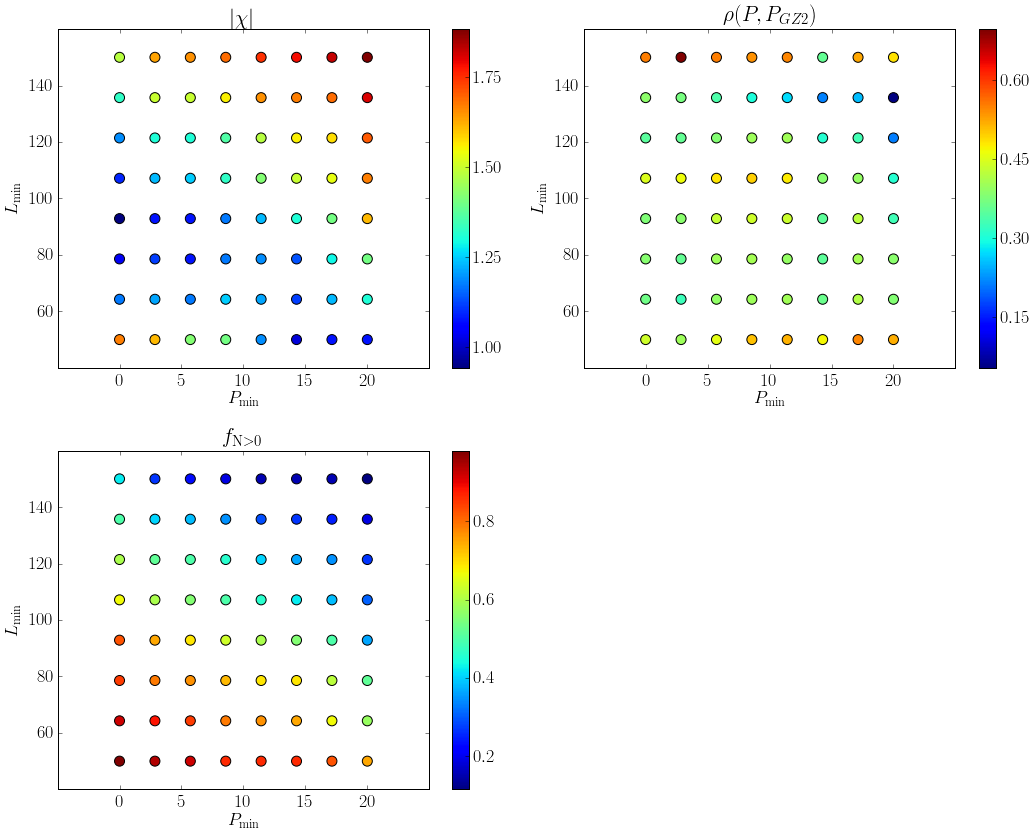

In [150]:
fig, axarr = plt.subplots(2,2,figsize=(15,12))
axarr = axarr.ravel()
fig.delaxes(axarr[-1])

plt.sca(axarr[0])
z = arm_stats['chi']
_ = plt.scatter(x,y,c=z,s=100)
plt.colorbar(_)
plt.xlabel('$P_\mathrm{min}$')
plt.ylabel('$L_\mathrm{min}$')
plt.title('$|\chi|$')

plt.sca(axarr[1])
z = arm_stats['rho']
colors = plt.cm.coolwarm(scaled_z)
_ = plt.scatter(x,y,c=z,s=100)
plt.colorbar(_)
plt.xlabel('$P_\mathrm{min}$')
plt.ylabel('$L_\mathrm{min}$')
plt.title(r'$\rho(P,P_{GZ2})$')

plt.sca(axarr[2])
z = arm_stats['f_ok']
colors = plt.cm.coolwarm(scaled_z)
_ = plt.scatter(x,y,c=z,s=100)
plt.colorbar(_)
plt.xlabel('$P_\mathrm{min}$')
plt.ylabel('$L_\mathrm{min}$')
plt.title(r'$f_\mathrm{N>0}$')

fig.tight_layout()

In [187]:
def bhattacharyya_test(x1,x2,bins):
    if isinstance(bins,float):
        x_min = np.min([np.min(x1),np.min(x2)])
        x_max = np.max([np.max(x1),np.max(x2)])
        bins = np.linspace(x_min,x_max,bins)
    N1, _ = np.histogram(x1,bins=bins)
    N2, _ = np.histogram(x2,bins=bins)
    p = N1/N1.sum()
    q = N2/N2.sum()
    bhattacharyya_coefficient = np.sqrt(p*q).sum()
    return bhattacharyya_coefficient